In [3]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(1)
    tf.config.experimental_connect_to_cluster(tpu)
    print(2)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print(3)
    strategy = tf.distribute.TPUStrategy(tpu)
    print(4)
    BATCH_SIZE = strategy.num_replicas_in_sync * 4
    print("Running on TPU:", tpu.master())
    print(f"Batch Size good: {BATCH_SIZE}")
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 32
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")  

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Running on 1 replicas
Batch Size: 32


In [4]:
import numpy as np 
import pandas as pd 




import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))




/kaggle/input/llm-detect-ai-generated-text-deobfuscation/train_from_LLM-Detect_AI-GT_1MNB-3SGD.csv
/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv


In [5]:
!pip install seaborn

In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc(y_test, y_pred):
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    
    roc_auc = auc(fpr, tpr)

    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    
    
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [7]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_precision_recall(y_test, y_pred):
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    
    auc_score = auc(recall, precision)

    
    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=1, label='PR curve (area = %0.2f)' % auc_score)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_test, y_pred):
    
    y_pred_class = np.where(y_pred > 0.5, 1, 0)  

    cm = confusion_matrix(y_test, y_pred_class)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

In [9]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_loss(history):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [10]:
from IPython.display import clear_output

In [11]:
import pandas as pd
train1=pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")


train2=pd.read_csv("/kaggle/input/llm-detect-ai-generated-text-deobfuscation/train_from_LLM-Detect_AI-GT_1MNB-3SGD.csv")
train2 = train2.drop(['id','prompt_id'], axis=1)

train = pd.concat([train1, train2])


In [12]:

class_counts = train['label'].value_counts()


minority_class_count = class_counts.min()


train_balanced = pd.concat([
    train[train['label'] == label].sample(n=minority_class_count, replace=False, random_state=42)
    for label in class_counts.index
])


train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
train = train_balanced

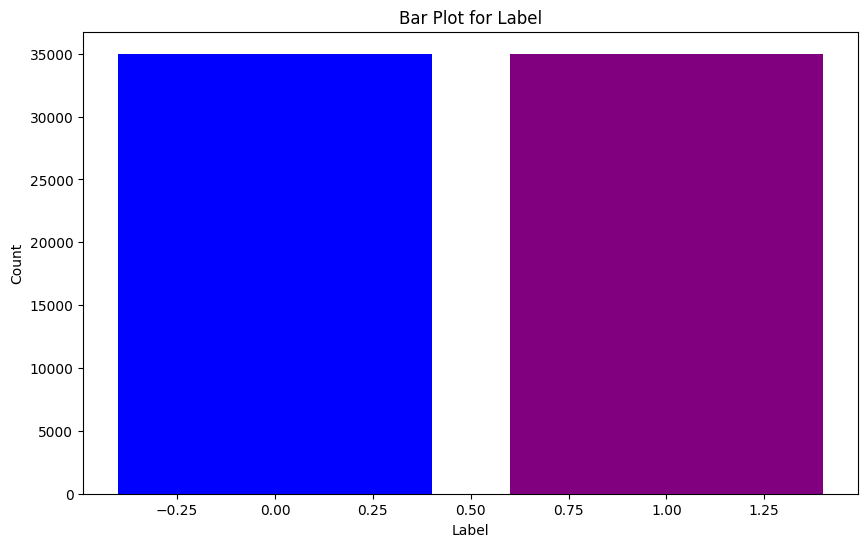

In [13]:

label_counts = train['label'].value_counts()

plt.figure(figsize=(10,6))
plt.bar(label_counts.index, label_counts.values, color=['blue','purple'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Bar Plot for Label')
plt.show()

In [14]:
train.head(5)

,text,label,prompt_name,source,RDizzl3_seven
0,Dear PrincipalI think we should perform commun...,0,Community service,persuade_corpus,False
1,"Dear Senator,\n\nI am writing to you today wit...",1,Does the electoral college work?,radekgpt4,True
2,Phones and drivingI believe that despite the g...,0,Phones and driving,persuade_corpus,False
3,"Dear Senator,\n\nI am writing to express my v...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True
4,"In today's society, character traits are a cru...",1,Seeking multiple opinions,mistral7binstruct_v1,False


In [15]:
!pip install nltk

In [16]:
import re
import nltk
from nltk.corpus import stopwords


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def clean_text(text):
    
    text = text.lower()
    
    
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    

    
    text = re.sub(r'[^\w\s]', ' ', text)
    
    
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
train['text'] = train['text'].apply(clean_text)


In [18]:
train.head(5)

,text,label,prompt_name,source,RDizzl3_seven
0,dear principali think perform community servic...,0,Community service,persuade_corpus,False
1,dear senator writing today intention sparking ...,1,Does the electoral college work?,radekgpt4,True
2,phones drivingi believe despite good comes pho...,0,Phones and driving,persuade_corpus,False
3,dear senator writing express views electoral c...,1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True
4,today society character traits crucial aspect ...,1,Seeking multiple opinions,mistral7binstruct_v1,False


In [19]:

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train['text'], train['label'], test_size=0.2, random_state=42)



In [22]:
lunghezze_testi_mediana=512

In [23]:
!pip install transformers

In [24]:
from transformers import AutoTokenizer,TFBertModel


model_check='bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_check)

def encode_text(text, tokenizer):
    encoded = tokenizer.batch_encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors="tf",
    )
    
    input_ids = np.array(encoded["input_ids"], dtype="int32")
    attention_masks = np.array(encoded["attention_mask"], dtype="int32")

    return {
        "input_ids": input_ids,
        "attention_masks": attention_masks
    }

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:

encoded_train_text = encode_text(X_train.tolist(), tokenizer)
encoded_val_text = encode_text(X_test.tolist(), tokenizer)


In [27]:

input_ids_train = tf.convert_to_tensor(encoded_train_text["input_ids"])
attention_masks_train = tf.convert_to_tensor(encoded_train_text["attention_masks"])
input_ids_val = tf.convert_to_tensor(encoded_val_text["input_ids"])
attention_masks_val = tf.convert_to_tensor(encoded_val_text["attention_masks"])


Y_train = tf.convert_to_tensor(Y_train.tolist())
Y_test = tf.convert_to_tensor(Y_test.tolist())


In [28]:

early_stopping = EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=3, 
    mode='min', 
    restore_best_weights=True
)

In [29]:
from tensorflow.keras import Input, Model, regularizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from transformers import TFBertModel

with strategy.scope():
    
    input_ids_in = Input(shape=(None,), name='input_ids', dtype='int32')
    input_masks_in = Input(shape=(None,), name='attention_masks', dtype='int32')

    
    transformer_model = TFBertModel.from_pretrained('bert-base-uncased')

    embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
    embedding = GlobalAveragePooling1D()(embedding_layer)

    
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(embedding)
    x = Dropout(0.5)(x)

    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input_ids_in, input_masks_in], outputs=output)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])


In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, None)]               0         []                            
 r)                                                                                               
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_masks[0][0]']     
                             hidden_state=(None, None,                                        

In [32]:
history = model.fit(
    [input_ids_train, attention_masks_train], 
    Y_train, 
    validation_data=([input_ids_val, attention_masks_val], Y_test),
    batch_size=32, 
    epochs=10, 
    callbacks=[early_stopping]
)

Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'model/tf_bert_model/bert/encoder/layer_._5/attention/self/Softmax' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_42/658995977.py", line 1, in <module>
      history = model.fit(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1061, in run_call_with_unpacked_inputs
      Base class for all TF models.
    File "/opt/conda/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 1088, in call
      outputs = self.bert(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1061, in run_call_with_unpacked_inputs
      Base class for all TF models.
    File "/opt/conda/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 862, in call
      encoder_outputs = self.encoder(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 548, in call
      for i, layer_module in enumerate(self.layer):
    File "/opt/conda/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 554, in call
      layer_outputs = layer_module(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 464, in call
      self_attention_outputs = self.attention(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 380, in call
      self_outputs = self.self_attention(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 319, in call
      attention_probs = stable_softmax(logits=attention_scores, axis=-1)
    File "/opt/conda/lib/python3.10/site-packages/transformers/tf_utils.py", line 70, in stable_softmax
      return tf.nn.softmax(logits=logits + 1e-9, axis=axis, name=name)
Node: 'model/tf_bert_model/bert/encoder/layer_._5/attention/self/Softmax'
OOM when allocating tensor with shape[32,12,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/tf_bert_model/bert/encoder/layer_._5/attention/self/Softmax}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_37352]

In [ ]:
history.history

In [ ]:
plot_accuracy(history)

In [ ]:
plot_loss(history)

In [ ]:
y_pred = model.predict([[input_ids_val, attention_masks_val]])

In [ ]:
plot_confusion_matrix(Y_test, y_pred)

In [ ]:
plot_roc(Y_test, y_pred)

In [ ]:
human_text = """I think reusable metal water bottles are one of the best things ever created. I don't hate. They are useful for everything and can often keep the temperature of the water inside very cool, or warm depending on when you use it. The price is justified by the fact that the material is more expensive than plain plastic, and thus splashes higher. Since there is Amazon or other sales sites, most people I know use these water bottles now. I'm glad I acquired it, because I don't buy water bottles now when I'm out for a very long time."""
gpt_text = """
Reusable metal water bottles have had a profound impact on modern society. They're practical, cost-effective, and environmentally friendly, transforming how people stay hydrated on the go.

Their durability and insulation make them versatile for various activities, reducing the need for frequent replacements. While they might seem pricier initially, their long-term use saves money and decreases plastic waste significantly.

Most importantly, they've spurred a shift in habits, becoming a symbol of environmentally conscious choices. Their widespread adoption highlights a move away from single-use plastic bottles, promoting sustainability in everyday life. These bottles are a practical, eco-friendly, and impactful choice in today's world."""

wikipedia="""Metin2 is a massively multiplayer online role-playing game (MMORPG) originally developed by Ymir Entertainment (now owned by Webzen Games) and originally released in Korea in 2004.[1] It has since been published in many European countries and in the United States by Gameforge 4D GmbH.[2] Other versions exist in Asian languages.

Experience points are earned every time the player kills enemies or completes a mission from an NPC. The game's combat is based on a hack and slash system. Players can also gather groups of creatures and land basic attacks and skills on each one of them simultaneously while they are all attacking the character at the same time. The game has several different character classes, all of which have 2 different sets of skills they can use, which can also be upgraded.

The in-game currency is called Yang, used to purchase items from the different NPC's. Players can use this to trade with other players or to their own shop. Players can also make their own guild of fighters and guilds can have wars with each other."""

human2 = """Thus, if your foundation is strong, the building will be a strong one too. However, a weak foundation cannot make a building stand. In other words, student life helps us embrace human qualities.

People don’t realize how lucky and privileged one is to even get a student life. Many children dream of having it but never get one. Thus, if one gets to attain education, one must make the most of it.

Student life won’t always be filled with happiness but it will be worthwhile. It helps us grow in the path of life and acquire qualities such as honesty, patience, perseverance, and more."""

reddit = """There seems to be a somewhat viral underground theory that the events of nier automata repeat. Every time the overall story is discussed it’s a pretty safe bet someone in the comments brings up cycles. I don’t understand this bc multiple events are discrete one time events (Engels uncovering the alien ship, bunker exploding) and we have a pretty solid timeline of when major things happen (2B is only ~3 years old, 9S not that much older).

I would get it in terms of Accord but those are all separate timelines, they don’t interact or loop (a la nier anime vs game, or drakengard 3 endings). There’s also the idea that cathedral city is from a future after automata, creating a closed loop for maso, dragons, and the flower, but I almost exclusively see “cycles” mentioned in the context of automata. I’d assume it’s misinterpreting the repeated deaths of 9S and the trio’s resuscitation at the end of automata’s E but it seems too popular an idea to be from a simple misunderstanding."""

In [ ]:
texts = [human_text, gpt_text,wikipedia, human2,reddit]

v = list(map(clean_text, texts))
print(v)
res = encode_text(texts, tokenizer)
print(res)

In [ ]:
preds = model.predict(res)

In [ ]:
for p in preds:
    print(f"Predicted class: {p}")

In [ ]:
model.save("Finetuned-BERT.h5")